# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy import stats
import mne
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFECV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
import shap
import statsmodels.api as sm
from statsmodels.formula.api import logit
import warnings


# Data Preparation

In [2]:

old = "old_results_all.csv"
young = "young_results_all.csv"
old_df = pd.read_csv(old)
young_df = pd.read_csv(young)

combined_df = pd.concat([old_df, young_df], ignore_index=True)

old_male_id = old_df[old_df['group'].str.contains('Male')]['subject_id'].unique()
old_female_id = old_df[old_df['group'].str.contains('Female')]['subject_id'].unique()

print(f"Number of old male participants: {len(old_male_id)}")
print(f"Number of old female participants: {len(old_female_id)}")


young_male_id = combined_df[(combined_df['age_group'] == 'young') & (combined_df['group'].str.contains('Male'))]['subject_id'].unique()
print(f"Number of young male participants: {len(young_male_id)}")

young_female_id = combined_df[(combined_df['age_group'] == 'young') & (combined_df['group'].str.contains('Female'))]['subject_id'].unique()
print(f"Number of young female participants: {len(young_female_id)}")

young_male_subjects = np.random.choice(young_male_id, size=18, replace=False)
young_female_subjects = np.random.choice(young_female_id, size=11, replace=False)

selected_young_subjects = np.concatenate([young_male_subjects, young_female_subjects])


# Create a new dataframe with the selected subjects both old and young
selected_subjects = np.concatenate([old_male_id, old_female_id, selected_young_subjects])
print("-" * 100)
print(f"Selected subjects: {selected_subjects}")
print(len(selected_subjects))

# Turn this into a dataframe
new_df = combined_df[combined_df['subject_id'].isin(selected_subjects)]

Number of old male participants: 19
Number of old female participants: 10
Number of young male participants: 28
Number of young female participants: 11
----------------------------------------------------------------------------------------------------
Selected subjects: ['sub-010290' 'sub-010276' 'sub-010081' 'sub-010246' 'sub-010089'
 'sub-010257' 'sub-010289' 'sub-010088' 'sub-010268' 'sub-010272'
 'sub-010286' 'sub-010092' 'sub-010284' 'sub-010283' 'sub-010251'
 'sub-010267' 'sub-010085' 'sub-010245' 'sub-010243' 'sub-010258'
 'sub-010242' 'sub-010291' 'sub-010086' 'sub-010090' 'sub-010250'
 'sub-010249' 'sub-010247' 'sub-010277' 'sub-010244' 'sub-010315'
 'sub-010252' 'sub-010227' 'sub-010303' 'sub-010263' 'sub-010230'
 'sub-010241' 'sub-010261' 'sub-010162' 'sub-010195' 'sub-010271'
 'sub-010299' 'sub-010228' 'sub-010269' 'sub-010317' 'sub-010298'
 'sub-010053' 'sub-010304' 'sub-010075' 'sub-010155' 'sub-010266'
 'sub-010084' 'sub-010064' 'sub-010164' 'sub-010083' 'sub-010157'
 '

## Normalize the power


The following code implements a subject-specific normalization approach:

1. **Create a working copy** of the original dataframe to preserve raw data
2. **Iterate through each subject** to handle individual differences
3. **Process each condition-band combination** separately for proper normalization context
4. **Calculate normalization factor** as the sum of power values across all regions
5. **Normalize region-specific power** by dividing by the total power

This approach ensures that power comparisons between regions account for individual 
differences in overall signal strength while maintaining the relative distribution 
across brain regions.

In [3]:
new_df_normalized = new_df.copy()
for subject in new_df['subject_id'].unique():
    subjectdf = new_df[new_df['subject_id'] == subject]

    for condition in subjectdf['condition'].unique():
        for band in subjectdf['band'].unique():
            normalizs = subjectdf[(subjectdf['condition'] == condition) & (subjectdf['band'] == band)]['power'].sum()
            for region in subjectdf['region'].unique():
                power = subjectdf[(subjectdf['condition'] == condition) & (subjectdf['band'] == band) & (subjectdf['region'] == region)]['power'].values[0]
                new_df_normalized.loc[(new_df_normalized['subject_id'] == subject) & (new_df_normalized['condition'] == condition) & (new_df_normalized['band'] == band) & (new_df_normalized['region'] == region),'normalized_power'] = power / normalizs

new_df_normalized


,subject_id,group,age_group,condition,region,band,power,normalized_power
0,sub-010290,Male_60-65,older,EC,occipital,alpha,4.101482e+29,0.446435
1,sub-010290,Male_60-65,older,EC,occipital,beta,2.158499e+29,0.336308
2,sub-010290,Male_60-65,older,EC,occipital,theta,8.683016e+28,0.331787
3,sub-010290,Male_60-65,older,EC,parietal,alpha,2.020458e+29,0.219921
4,sub-010290,Male_60-65,older,EC,parietal,beta,1.411419e+29,0.219908
...,...,...,...,...,...,...,...,...
1627,sub-010157,Female_20-25,young,EO,temporal,beta,6.576708e+28,0.213389
1628,sub-010157,Female_20-25,young,EO,temporal,theta,5.053774e+28,0.211244
1629,sub-010157,Female_20-25,young,EO,frontal,alpha,4.295043e+28,0.129743
1630,sub-010157,Female_20-25,young,EO,frontal,beta,5.571163e+28,0.180763


# Plots

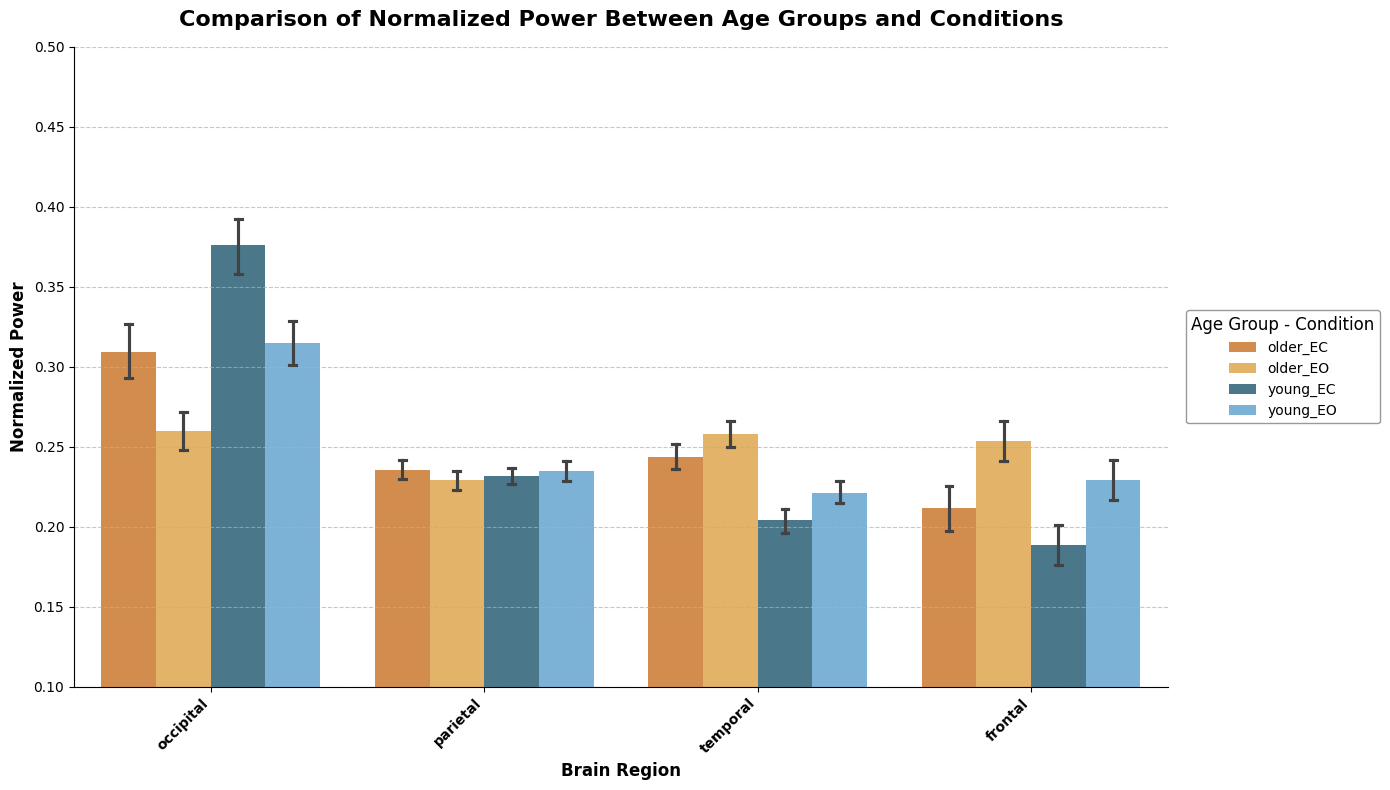

In [4]:
plt.figure(figsize=(14, 8))

# Create a new column that combines age_group and condition for grouping
new_df_normalized['group_condition'] = new_df_normalized['age_group'] + '_' + new_df_normalized['condition']

# Define a custom palette
palette = {
    'young_EC': '#2b6d89',    # Darker blue for young EC
    'young_EO': '#5dade2',    # Lighter blue for young EO
    'older_EC': '#e67e22',    # Darker orange for older EC
    'older_EO': '#f5b041'     # Lighter orange for older EO
}

# Create the grouped barplot
ax = sns.barplot(
    x='region', 
    y='normalized_power', 
    data=new_df_normalized, 
    hue='group_condition',
    palette=palette, 
    errorbar=('ci', 95),
    capsize=0.1,
    width=0.8,
    alpha=0.9
)

# Add grid and labels
plt.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)
plt.title('Comparison of Normalized Power Between Age Groups and Conditions', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Brain Region', fontsize=12, fontweight='bold')
plt.ylabel('Normalized Power', fontsize=12, fontweight='bold')

# Format x-tick labels
plt.xticks(fontweight='bold', rotation=45, ha='right')

# Set y-axis limits
plt.ylim([0.10, 0.50])
plt.yticks(np.arange(0.10, 0.55, 0.05))

# Format the legend
plt.legend(
    title='Age Group - Condition', 
    title_fontsize=12, 
    frameon=True, 
    facecolor='white', 
    edgecolor='gray',
    bbox_to_anchor=(1.01, 0.5),
    loc='center left'
)

# Hide top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

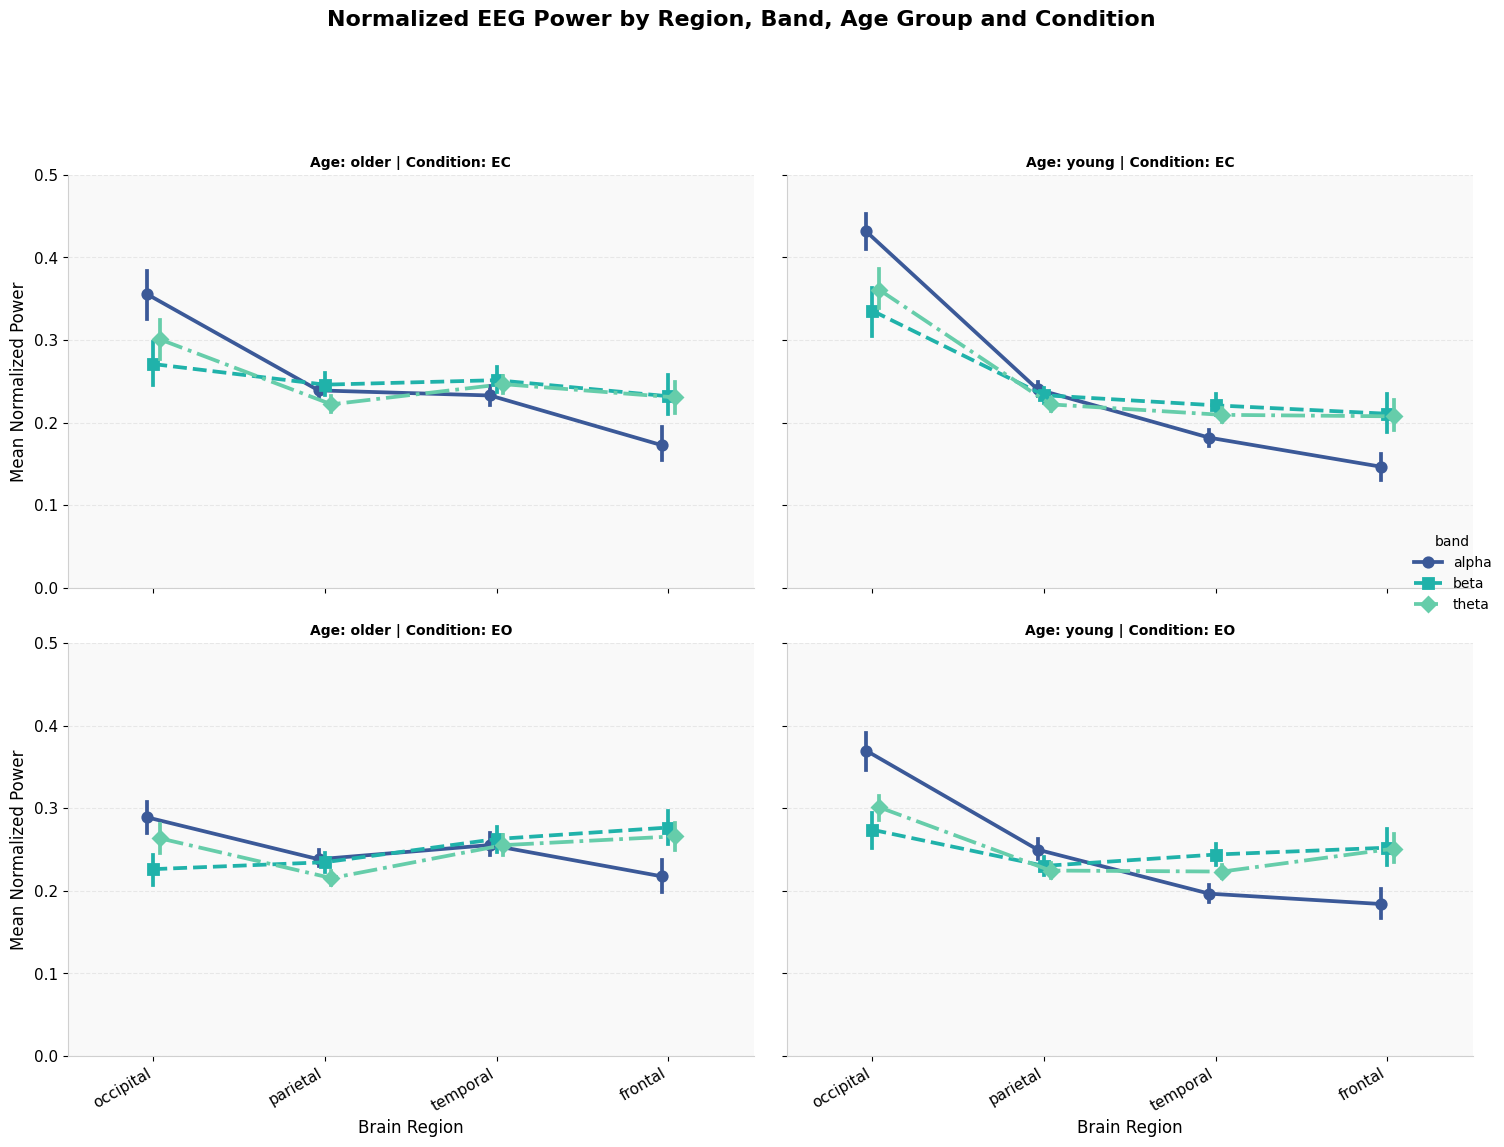

In [5]:
# Create an improved 2x2 facet grid
g = sns.catplot(
    data=new_df_normalized, 
    x='region',
    y='normalized_power',
    hue='band',
    col='age_group',
    row='condition',
    kind='point',
    dodge=True,
    errorbar=('ci', 95),
    palette=['#3b5998', '#20b2aa', '#66cdaa'],  # Better color contrast
    height=5.5,
    aspect=1.3,
    markers=['o', 's', 'D'],
    linestyles=['-', '--', '-.'],
    sharex=True,
    sharey=True,
    legend_out=True
)

# Enhance labels and titles
g.set_axis_labels("Brain Region", "Mean Normalized Power", fontsize=12)
g.set_titles("Age: {col_name} | Condition: {row_name}", fontsize=13, fontweight='bold')
g.set_xticklabels(fontsize=11, rotation=30, ha='right')  # Better readability

# Improve y-axis appearance
for ax in g.axes.flat:
    ax.set_ylim(0, 0.5)  # Consistent y-axis with some headroom
    ax.tick_params(axis='y', labelsize=11)
    ax.yaxis.grid(True, linestyle='--', alpha=0.7, color='#E0E0E0')
    
    # Add subtle background for better readability
    ax.set_facecolor('#f9f9f9')
    
    # Add subtle spines
    for spine in ax.spines.values():
        spine.set_color('#D0D0D0')
        spine.set_linewidth(0.8)


# Add a main title with better positioning
plt.suptitle('Normalized EEG Power by Region, Band, Age Group and Condition', 
             y=1.05, fontsize=16, fontweight='bold')
# After creating the plot, add these lines:
regions = new_df_normalized['region'].unique()
for i, ax in enumerate(g.axes.flat):
    ax.set_xticks(range(len(regions)))
    ax.set_xticklabels(regions, fontsize=11, rotation=30, ha='right')
# Adjust layout
plt.tight_layout(pad=2.0)
plt.subplots_adjust(top=0.9)

/var/folders/5l/_j849hgd3cg7z8sc6pzdrt2c0000gn/T/ipykernel_35071/261940682.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Make room for colorbar


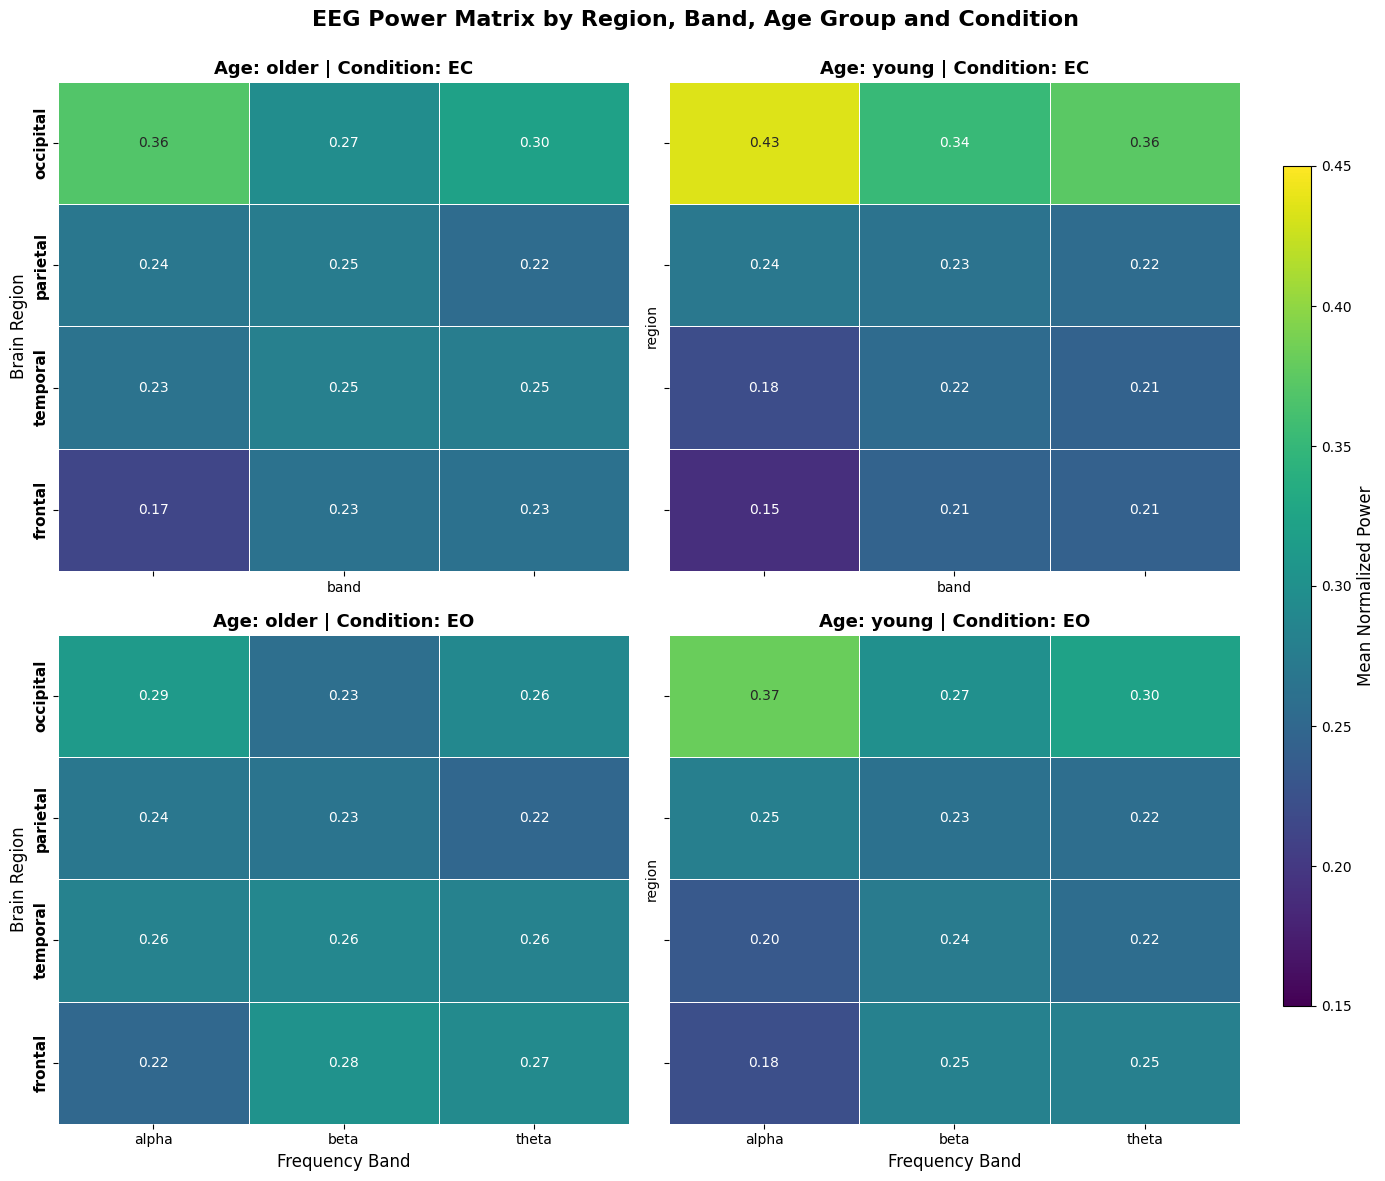

In [6]:
# Create a 2x2 grid for our four conditions (age_group × condition)
fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharex=True, sharey=True)

# Define age groups and conditions
age_groups = ['older', 'young']
conditions = ['EC', 'EO']

# Get unique region names to ensure consistency
regions = new_df_normalized['region'].unique()

# Custom colormap with better perceptual properties
cmap = sns.color_palette("viridis", as_cmap=True)

# Loop through each combination and create a heatmap
for i, condition in enumerate(conditions):
    for j, age in enumerate(age_groups):
        # Filter data for this subplot
        subset = new_df_normalized[(new_df_normalized['age_group'] == age) & 
                                   (new_df_normalized['condition'] == condition)]
        
        # Create pivot table for this specific combination
        pivot = subset.pivot_table(
            index='region', 
            columns='band', 
            values='normalized_power',
            aggfunc='mean'
        )
        
        # Ensure pivot table has consistent row order matching regions list
        pivot = pivot.reindex(regions)
        
        sns.heatmap(
            pivot, 
            ax=axes[i, j],
            cmap=cmap,
            vmin=0.10,
            vmax=0.45,
            annot=True,
            fmt='.2f',
            linewidths=0.5,
            cbar=False  # No colorbar on any subplot
        )
        
        # Add titles
        axes[i, j].set_title(f"Age: {age} | Condition: {condition}", 
                             fontsize=13, fontweight='bold')
        
        # Ensure region names are clearly displayed
        axes[i, j].set_yticklabels(regions, fontsize=11, fontweight='bold')
        
        # Set x/y labels only for outer subplots
        if i == 1:
            axes[i, j].set_xlabel('Frequency Band', fontsize=12)
        if j == 0:
            axes[i, j].set_ylabel('Brain Region', fontsize=12)

# Add a main title
plt.suptitle('EEG Power Matrix by Region, Band, Age Group and Condition', 
             y=0.98, fontsize=16, fontweight='bold')

# Add a single colorbar for the entire figure
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [x, y, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0.15, 0.45))
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Mean Normalized Power', fontsize=12)

# Adjust spacing
plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Make room for colorbar
plt.subplots_adjust(top=0.92)

# Statistical Analysis

## Converting dataset **Long** -> **Wide**

Ok So given the current format of my data set I will be turning my dataframe from long to wide format

In [7]:
new_df_normalized['feature_name'] = new_df_normalized['condition'] + '_' + new_df_normalized['band'] + '_' + new_df_normalized['region'] # a new column that contains the feature name
print(new_df_normalized['feature_name'])

0       EC_alpha_occipital
1        EC_beta_occipital
2       EC_theta_occipital
3        EC_alpha_parietal
4         EC_beta_parietal
               ...        
1627      EO_beta_temporal
1628     EO_theta_temporal
1629      EO_alpha_frontal
1630       EO_beta_frontal
1631      EO_theta_frontal
Name: feature_name, Length: 1392, dtype: object


In [8]:
new_df_normalized
new_df_normalized = new_df_normalized.drop('power', axis=1)

In [9]:
new_df_normalized

,subject_id,group,age_group,condition,region,band,normalized_power,group_condition,feature_name
0,sub-010290,Male_60-65,older,EC,occipital,alpha,0.446435,older_EC,EC_alpha_occipital
1,sub-010290,Male_60-65,older,EC,occipital,beta,0.336308,older_EC,EC_beta_occipital
2,sub-010290,Male_60-65,older,EC,occipital,theta,0.331787,older_EC,EC_theta_occipital
3,sub-010290,Male_60-65,older,EC,parietal,alpha,0.219921,older_EC,EC_alpha_parietal
4,sub-010290,Male_60-65,older,EC,parietal,beta,0.219908,older_EC,EC_beta_parietal
...,...,...,...,...,...,...,...,...,...
1627,sub-010157,Female_20-25,young,EO,temporal,beta,0.213389,young_EO,EO_beta_temporal
1628,sub-010157,Female_20-25,young,EO,temporal,theta,0.211244,young_EO,EO_theta_temporal
1629,sub-010157,Female_20-25,young,EO,frontal,alpha,0.129743,young_EO,EO_alpha_frontal
1630,sub-010157,Female_20-25,young,EO,frontal,beta,0.180763,young_EO,EO_beta_frontal


In [10]:
wide_df = new_df_normalized.pivot_table(
    index = "subject_id", # unique identifier for each subject
    columns= 'feature_name', # the feature name
    values = 'normalized_power', # the values to be pivoted
    aggfunc = 'first' # how to handle duplicate values
)
wide_df = wide_df.reset_index()
wide_df.head(5)


feature_name,subject_id,EC_alpha_frontal,EC_alpha_occipital,EC_alpha_parietal,EC_alpha_temporal,EC_beta_frontal,EC_beta_occipital,EC_beta_parietal,EC_beta_temporal,EC_theta_frontal,...,EO_alpha_parietal,EO_alpha_temporal,EO_beta_frontal,EO_beta_occipital,EO_beta_parietal,EO_beta_temporal,EO_theta_frontal,EO_theta_occipital,EO_theta_parietal,EO_theta_temporal
0,sub-010053,0.172379,0.401070,0.229118,0.197433,0.229893,0.305814,0.239386,0.224907,0.227364,...,0.221068,0.189397,0.230960,0.298981,0.257067,0.212992,0.264798,0.312401,0.208811,0.213990
1,sub-010064,0.108789,0.465859,0.239390,0.185962,0.159701,0.330507,0.259059,0.250733,0.160871,...,0.234318,0.176686,0.176622,0.328522,0.242336,0.252520,0.201957,0.356034,0.210874,0.231135
2,sub-010075,0.173375,0.403578,0.231360,0.191687,0.230233,0.333030,0.219817,0.216920,0.217191,...,0.215542,0.163581,0.299157,0.285523,0.217928,0.197392,0.291610,0.304627,0.219749,0.184014
3,sub-010081,0.153305,0.408892,0.237621,0.200182,0.177373,0.333897,0.263517,0.225213,0.218159,...,0.244455,0.223120,0.200729,0.293700,0.262378,0.243193,0.236725,0.279820,0.232941,0.250513
4,sub-010083,0.111199,0.435258,0.264328,0.189215,0.171072,0.370679,0.258613,0.199635,0.194240,...,0.271586,0.150843,0.273485,0.269190,0.263171,0.194154,0.270777,0.287813,0.240773,0.200638


### Adding Demographics


In [11]:
age_group = new_df_normalized[['subject_id', 'age_group']].drop_duplicates()
value_counts = age_group['age_group'].value_counts()
print(f"Age group info: ")
print(value_counts)
gender_info = new_df_normalized[['subject_id', 'group']].drop_duplicates()
print(f"Gender info: ")
gender_info['gender'] = gender_info['group'].apply(
    lambda x: 'Female' if 'Female' in x else 'Male')
gender_value_counts = gender_info['gender'].value_counts()
print(gender_value_counts)

wide_df = wide_df.merge(age_group, on='subject_id')
wide_df = wide_df.merge(gender_info[['subject_id', 'gender']], on='subject_id')

wide_df.head(5)



Age group info: 
age_group
older    29
young    29
Name: count, dtype: int64
Gender info: 
gender
Male      37
Female    21
Name: count, dtype: int64


,subject_id,EC_alpha_frontal,EC_alpha_occipital,EC_alpha_parietal,EC_alpha_temporal,EC_beta_frontal,EC_beta_occipital,EC_beta_parietal,EC_beta_temporal,EC_theta_frontal,...,EO_beta_frontal,EO_beta_occipital,EO_beta_parietal,EO_beta_temporal,EO_theta_frontal,EO_theta_occipital,EO_theta_parietal,EO_theta_temporal,age_group,gender
0,sub-010053,0.172379,0.401070,0.229118,0.197433,0.229893,0.305814,0.239386,0.224907,0.227364,...,0.230960,0.298981,0.257067,0.212992,0.264798,0.312401,0.208811,0.213990,young,Male
1,sub-010064,0.108789,0.465859,0.239390,0.185962,0.159701,0.330507,0.259059,0.250733,0.160871,...,0.176622,0.328522,0.242336,0.252520,0.201957,0.356034,0.210874,0.231135,young,Female
2,sub-010075,0.173375,0.403578,0.231360,0.191687,0.230233,0.333030,0.219817,0.216920,0.217191,...,0.299157,0.285523,0.217928,0.197392,0.291610,0.304627,0.219749,0.184014,young,Female
3,sub-010081,0.153305,0.408892,0.237621,0.200182,0.177373,0.333897,0.263517,0.225213,0.218159,...,0.200729,0.293700,0.262378,0.243193,0.236725,0.279820,0.232941,0.250513,older,Male
4,sub-010083,0.111199,0.435258,0.264328,0.189215,0.171072,0.370679,0.258613,0.199635,0.194240,...,0.273485,0.269190,0.263171,0.194154,0.270777,0.287813,0.240773,0.200638,young,Female


In [12]:
wide_df.shape


(58, 27)

## Random Forest

### Building the model

In [13]:
import optuna
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score
X = wide_df.drop(columns=['subject_id', 'age_group', 'gender'])
y = wide_df['age_group']
y_binary = (y == 'older').astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.25, random_state=42, stratify=y_binary
)

print(f"\nTraining set: {X_train.shape[0]} subjects")
print(f"Testing set: {X_test.shape[0]} subjects")


def objective(trial):
    # Define the hyperparameter search space
    k_best = trial.suggest_int('k_best', 10, min(50, X_train.shape[1]))
    
    # Random Forest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Create pipeline with trial parameters
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', SelectKBest(f_classif, k=k_best)),
        ('classifier', RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        ))
    ])
    
    # Use cross-validation to evaluate the model
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc')
    return scores.mean()

# Create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, n_jobs=-1)  # Adjust number of trials as needed

# Print the best parameters and score
print("Best trial:")
trial = study.best_trial
print(f"  ROC AUC: {trial.value:.4f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Create final model with best parameters
best_k = trial.params['k_best']
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(f_classif, k=best_k)),
    ('classifier', RandomForestClassifier(
        n_estimators=trial.params['n_estimators'],
        max_depth=trial.params['max_depth'],
        min_samples_split=trial.params['min_samples_split'],
        min_samples_leaf=trial.params['min_samples_leaf'],
        random_state=42
    ))
])

# Train on the full training set
pipeline.fit(X_train, y_train)

# Evaluate on the test set
y_pred = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
test_roc_auc = roc_auc_score(y_test, y_pred)

print(f"\nTest accuracy: {test_accuracy:.4f}")
print(f"Test ROC AUC: {test_roc_auc:.4f}")

# To see which features were selected
selected_features = X.columns[pipeline.named_steps['selector'].get_support()]
print(f"\nSelected features ({len(selected_features)}):")
print(selected_features.tolist())

[I 2025-04-10 19:07:22,655] A new study created in memory with name: no-name-55e748b0-c9d6-4a28-8720-e9bd82cff18a



Training set: 43 subjects
Testing set: 15 subjects


[I 2025-04-10 19:07:24,423] Trial 1 finished with value: 0.93 and parameters: {'k_best': 24, 'n_estimators': 57, 'max_depth': 3, 'min_samples_split': 15, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.93.
[I 2025-04-10 19:07:24,482] Trial 10 finished with value: 0.9 and parameters: {'k_best': 17, 'n_estimators': 57, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.93.
[I 2025-04-10 19:07:24,803] Trial 8 finished with value: 0.9199999999999999 and parameters: {'k_best': 12, 'n_estimators': 73, 'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.93.
[I 2025-04-10 19:07:25,113] Trial 4 finished with value: 0.9199999999999999 and parameters: {'k_best': 22, 'n_estimators': 84, 'max_depth': 13, 'min_samples_split': 13, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.93.
[I 2025-04-10 19:07:25,494] Trial 2 finished with value: 0.9199999999999999 and parameters: {'k_best': 24, 'n_estimators': 9

Best trial:
  ROC AUC: 0.9400
  Params:
    k_best: 16
    n_estimators: 260
    max_depth: 17
    min_samples_split: 11
    min_samples_leaf: 6

Test accuracy: 0.8000
Test ROC AUC: 0.7857

Selected features (16):
['EC_alpha_frontal', 'EC_alpha_occipital', 'EC_alpha_temporal', 'EC_beta_occipital', 'EC_beta_temporal', 'EC_theta_frontal', 'EC_theta_occipital', 'EC_theta_temporal', 'EO_alpha_frontal', 'EO_alpha_occipital', 'EO_alpha_temporal', 'EO_beta_frontal', 'EO_beta_occipital', 'EO_beta_temporal', 'EO_theta_occipital', 'EO_theta_temporal']


### Explanation of the Metrics Above

**Accuracy** How many times the model correctly classified of all samples

**F1** This is the harmonic mean between the precision and recall


In [14]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
y_pred = pipeline.predict(X_test)
print("\nModel Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.3f}")


Model Performance:
Accuracy: 0.800
F1 Score: 0.727
ROC AUC: 0.786


Technically a 88 percent performance on 5 fold could be very accaptable but I dont know for a sample size as small as this one  will need to read more about this 


Cross-validation accuracy: 0.8273 ± 0.1081


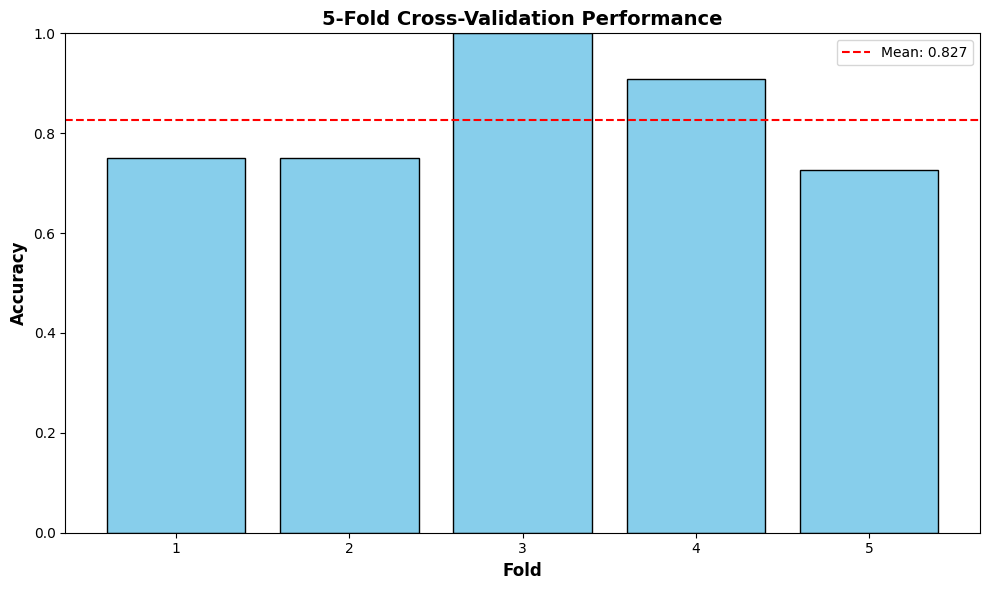

In [15]:
# 6. Cross-validation results
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X, y_binary, cv=cv, scoring='accuracy')
print(f"\nCross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
# Visualize cross-validation performance
plt.figure(figsize=(10, 6))
plt.bar(range(1, 6), cv_scores, color='skyblue', edgecolor='black')
plt.axhline(cv_scores.mean(), color='red', linestyle='--', label=f'Mean: {cv_scores.mean():.3f}')
plt.xlabel('Fold', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('5-Fold Cross-Validation Performance', fontsize=14, fontweight='bold')
plt.xticks(range(1, 6))
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()


Top 10 most important features:
               Feature  Importance
10   EO_alpha_temporal    0.274223
2    EC_alpha_temporal    0.222349
9   EO_alpha_occipital    0.144487
7    EC_theta_temporal    0.108486
1   EC_alpha_occipital    0.057201
12   EO_beta_occipital    0.041751
4     EC_beta_temporal    0.035520
6   EC_theta_occipital    0.019219
3    EC_beta_occipital    0.019128
15   EO_theta_temporal    0.018431


/Users/alpmac/anaconda3/envs/trento1/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectKBest was fitted without feature names
  warnings.warn(


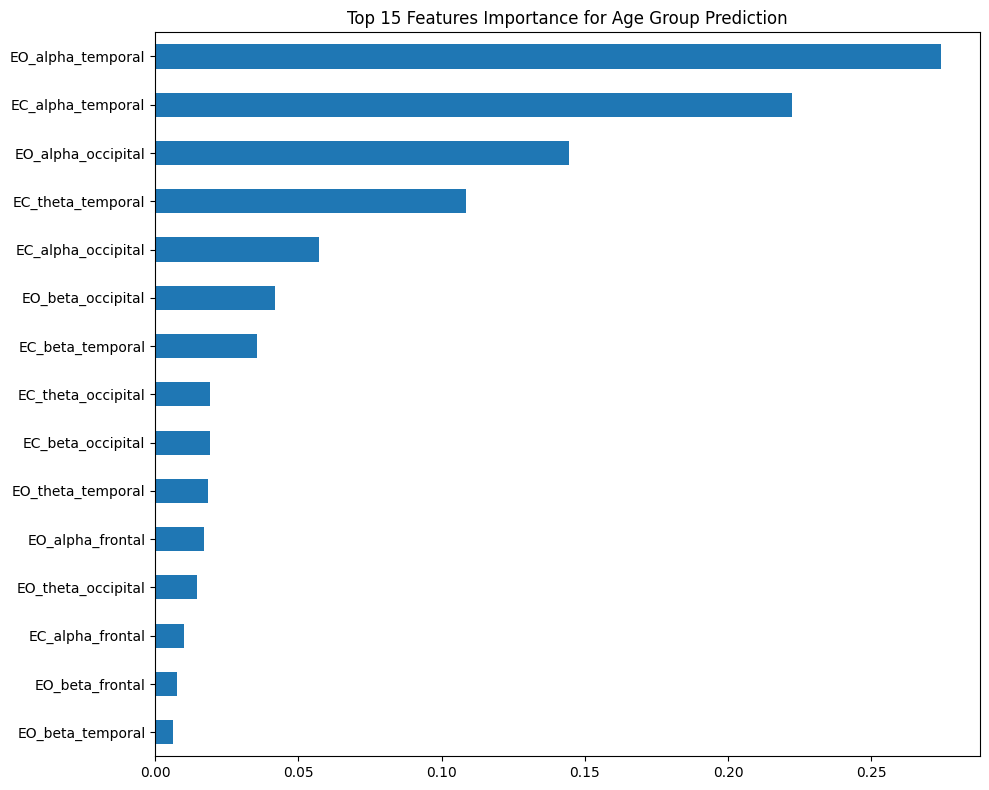

In [16]:
selected_indices = pipeline.named_steps['selector'].get_support(indices=True)
selected_features = X.columns[selected_indices].tolist()
importances = pipeline.named_steps['classifier'].feature_importances_
feature_importances = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances
})
feature_importances = feature_importances.sort_values('Importance', ascending=False)
print("Top 10 most important features:")
print(feature_importances.head(10))

# Get feature importance from Random Forest
selected_X_train = pipeline.named_steps['selector'].transform(X_train)
rf_classifier = pipeline.named_steps['classifier']
# Map importances back to original feature names
importances = pd.Series(
    rf_classifier.feature_importances_,
    index=selected_features
)

# Sort and visualize top features
plt.figure(figsize=(10, 8))
importances = importances.sort_values(ascending=False)
ax = importances[:15].plot(kind='barh')
ax.invert_yaxis()  # Display with highest importance at the top
plt.title('Top 15 Features Importance for Age Group Prediction')
plt.tight_layout()



In [17]:
# Enhance the statistical testing function
def add_enhanced_statistical_testing(features, df):
    results = []
    
    for feature in features:
        parts = feature.split('_')
        condition = parts[0]
        band = parts[1]
        region = '_'.join(parts[2:])
        
        # Get values for each group
        young_values = df[(df['age_group'] == 'young') & 
                         (df['condition'] == condition) & 
                         (df['band'] == band) & 
                         (df['region'] == region)]['normalized_power']
        
        older_values = df[(df['age_group'] == 'older') & 
                         (df['condition'] == condition) & 
                         (df['band'] == band) & 
                         (df['region'] == region)]['normalized_power']
        
        # Calculate means for both groups
        young_mean = young_values.mean()
        older_mean = older_values.mean()
        
        # Calculate percent difference
        percent_diff = ((older_mean - young_mean) / young_mean) * 100
        
        # Run t-test
        t_stat, p_value = stats.ttest_ind(older_values, young_values, equal_var=False)
        
        # Determine which group has higher power
        direction = "Older > Young" if t_stat > 0 else "Young > Older"
        
        # Add to results
        results.append({
            'Feature': feature,
            'Condition': condition,
            'Band': band,
            'Region': region,
            'Young Mean': young_mean,
            'Older Mean': older_mean,
            'Percent Diff': percent_diff,
            't-statistic': t_stat,
            'p-value': p_value,
            'Direction': direction,
            'Significant': p_value < 0.05,
            'Significance': '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'
        })
    
    return pd.DataFrame(results)

# Run enhanced statistical testing
enhanced_stats = add_enhanced_statistical_testing(feature_importances['Feature'], new_df_normalized)

# Group by region and sort by absolute t-statistic for better interpretation
enhanced_stats['Abs_t'] = abs(enhanced_stats['t-statistic'])
enhanced_stats_sorted = enhanced_stats.sort_values(['Region', 'Abs_t'], ascending=[True, False])

# Format p-values
enhanced_stats_sorted['p-value_fmt'] = enhanced_stats_sorted['p-value'].apply(
    lambda x: f"{x:.3e}" if x < 0.001 else f"{x:.3f}")

# Create a more readable display function
def display_region_stats(stats_df):
    # Define ANSI color codes for terminal output
    BOLD = '\033[1m'
    GREEN = '\033[92m'
    RED = '\033[91m'
    BLUE = '\033[94m'
    END = '\033[0m'
    
    # List of regions in the order we want to display (posterior to anterior, following PASA)
    regions = ['occipital', 'parietal', 'temporal', 'frontal']
    
    # Print header
    print(f"\n{BOLD}Statistical Analysis of EEG Power Differences Between Age Groups{END}")
    for region in regions:
        region_data = stats_df[stats_df['Region'] == region].copy()
        if len(region_data) > 0:
            # Print region header with posterior/anterior classification
            region_type = "POSTERIOR" if region in ['occipital', 'parietal'] else "ANTERIOR"
            print(f"\n{BOLD}{BLUE}Region: {region.upper()} ({region_type}){END}")
            print("-" * 100)
            
            # Print column headers
            print(f"{BOLD}{'Feature':<20} {'Band':<10} {'Condition':<10} {'Young':<10} {'Older':<10} {'%Diff':<10} {'t-stat':<10} {'p-value':<15} {'Significance':<15}{END}")
            print("-" * 100)
            
            # Print each row
            for _, row in region_data.iterrows():
                # Color code based on direction (green for older>young, red for young>older)
                color = GREEN if row['Direction'] == 'Older > Young' else RED
                sign = row['Significance']
                
                print(f"{row['Feature']:<20} {row['Band']:<10} {row['Condition']:<10} "
                      f"{row['Young Mean']:.3f}    {row['Older Mean']:.3f}    "
                      f"{color}{row['Percent Diff']:+.1f}%{END}    "
                      f"{row['t-statistic']:+.2f}    {row['p-value_fmt']:<15} "
                      f"{color}{sign}{END}")
    
    # Print summary relevant to the PASA model
    print(f"\n{BOLD}Summary of Findings Relevant to PASA Model:{END}")
    posterior_regions = stats_df[stats_df['Region'].isin(['occipital', 'parietal'])]
    anterior_regions = stats_df[stats_df['Region'].isin(['temporal', 'frontal'])]
    
    posterior_direction = posterior_regions['t-statistic'].mean() < 0
    anterior_direction = anterior_regions['t-statistic'].mean() > 0
    
    pasa_support = posterior_direction and anterior_direction
    
    print(f"Posterior regions (occipital, parietal): "
          f"{'Young > Older' if posterior_direction else 'Older > Young'} "
          f"(Mean t-stat: {posterior_regions['t-statistic'].mean():.2f})")
    
    print(f"Anterior regions (temporal, frontal): "
          f"{'Older > Young' if anterior_direction else 'Young > Older'} "
          f"(Mean t-stat: {anterior_regions['t-statistic'].mean():.2f})")
    

# Display the enhanced statistics
display_region_stats(enhanced_stats_sorted)


Statistical Analysis of EEG Power Differences Between Age Groups

Region: OCCIPITAL (POSTERIOR)
----------------------------------------------------------------------------------------------------
Feature              Band       Condition  Young      Older      %Diff      t-stat     p-value         Significance   
----------------------------------------------------------------------------------------------------
EO_alpha_occipital   alpha      EO         0.370    0.289    -21.9%    -5.21    2.934e-06       ***
EC_alpha_occipital   alpha      EC         0.432    0.356    -17.6%    -4.09    1.464e-04       ***
EC_theta_occipital   theta      EC         0.361    0.301    -16.7%    -3.43    0.001           **
EC_beta_occipital    beta       EC         0.335    0.271    -19.2%    -3.25    0.002           **
EO_beta_occipital    beta       EO         0.274    0.226    -17.4%    -3.25    0.002           **
EO_theta_occipital   theta      EO         0.301    0.264    -12.5%    -3.05    0.004

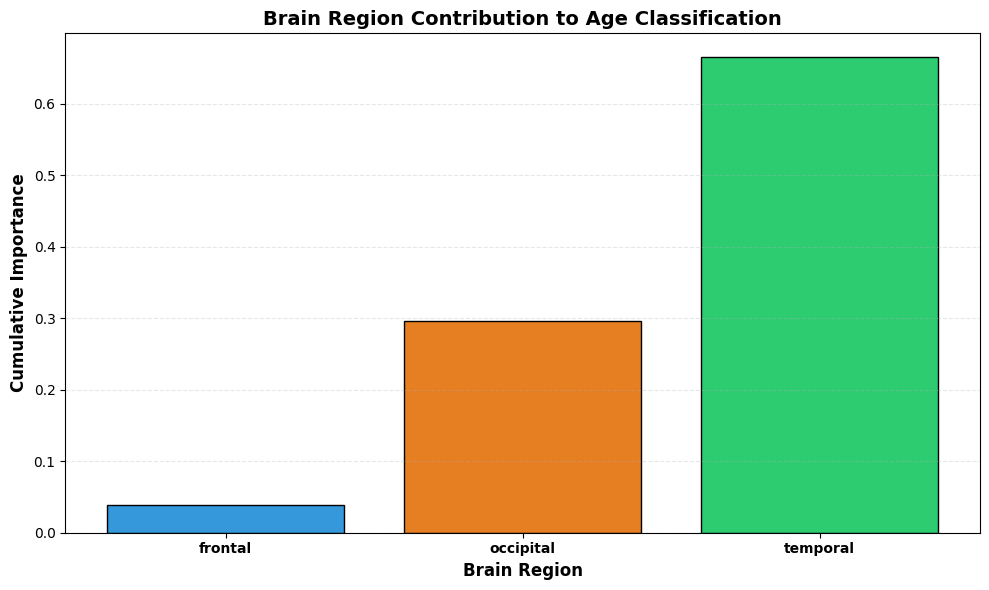

In [18]:
# Region-wise feature importance analysis
region_importances = {}

for feature, importance in zip(selected_features, rf_classifier.feature_importances_):
    # Extract region from feature name (assuming format like 'EC_alpha_occipital')
    region = feature.split('_')[-1]
    
    if region not in region_importances:
        region_importances[region] = 0
    region_importances[region] += importance

# Plot region-wise importance
plt.figure(figsize=(10, 6))
regions = list(region_importances.keys())
importances = list(region_importances.values())
colors = ['#3498db', '#e67e22', '#2ecc71', '#e74c3c']  # Same colors as before

plt.bar(regions, importances, color=colors, edgecolor='black')
plt.xlabel('Brain Region', fontsize=12, fontweight='bold')
plt.ylabel('Cumulative Importance', fontsize=12, fontweight='bold')
plt.title('Brain Region Contribution to Age Classification', fontsize=14, fontweight='bold')
plt.xticks(rotation=0, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()